# Preliminaries
In this first part we simply import all the libraries necessary to correctly run the whole project, we initialize GeDiM4Py and the geometry parameters for the mesh.

### Import libraries

In [1]:
%pip install pandas

import sys, time
sys.path.append('/content/CppToPython')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import GeDiM4Py as gedim

Note: you may need to restart the kernel to use updated packages.


### Initialize GeDiM4Py

In [2]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = {'GeometricTolerance': 1.0e-8}

gedim.Initialize(config, lib)

### Set geometry parameters

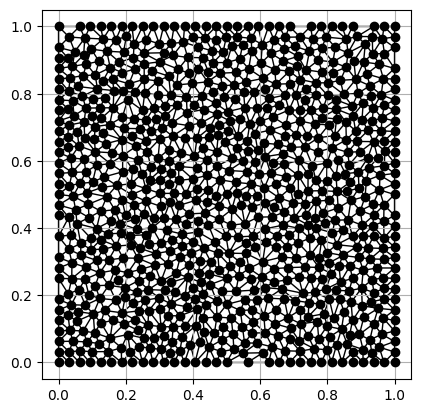

In [3]:
meshSize = 0.001
order = 1

# Used to compute the order of convergence
meshSizes = [0.1, 0.01, 0.001]

# Boundary conditions are all Homogenous Dirichlet BCs, we use only one marker (= 1) for the border
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
# Order=order -> Order of finite element
# BoundaryConditionsType=2 -> Dirichlet BCs
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotMesh(mesh)

# Nonlinear Elliptic Problem: POD vs PINNs and POD-nn

Aim of the project is to solve the following parametrized problem on the bidimensional spatial domain
\begin{equation*}
    \bar{\Omega} = [0, 1] \times [0, 1]
\end{equation*}
Given
\begin{equation*}
    \mathbf{\mu}=(\mu_0, \mu_1)\in\mathcal{P}=[0.1,1]\times[0.1,1]
\end{equation*}
find $u(\mathbf{\mu})$ such that
$$
\begin{cases}
\displaystyle - \Delta u(\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) = g(\mathbf{x};\mathbf{\mu}) & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω
\end{cases}
$$
Source term is defined as
\begin{equation*}
    g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
\end{equation*} 

## Weak Formulation
The weak formulation of the problem reads: find $u \in V := H^1_0(\Omega)$ such that
\begin{equation*}
    \int_{\Omega} \nabla u\cdot\nabla v + \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v - \int_{\Omega} g\, v = 0 \quad \forall v \in V
\end{equation*}
We can rearange this formulation as
\begin{equation*}
    f(u; v) := f_1(u; v) + f_2(u; v) + f_3(u; v) = 0 \quad \forall v \in V
\end{equation*}
having
$$
\begin{align*}
    f_1(u; v) &= \int_{\Omega} \nabla u\cdot\nabla v \\
    f_2(u; v) &= \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v \\
    f_3(u; v) &= - \int_{\Omega} g\, v
\end{align*}
$$

## Newton Schema
Since $f(u; v)$ is non-linear with respect to $\mu$, we are not able to separate variables, however we can implement the Newton schema in order to solve, for each iteration $k$, the following problem
\begin{equation*}
    J_f [\partial u]_{|_{u_k}} \partial u = - f(u_k; v) = 0 \quad \forall v \in V
\end{equation*}
having $J_f [\partial u]_{|_{u_k}}$ to be the evaluation of the Jacobian of $J_f$ in the point $u_k$ along the direction $\partial u$.

Both functions $f_1(u; v)$ and $f_3(u; v)$ are linear in $u$, this implies that their Gateux derivatives are respectively
$$
\begin{align*}
    J_{f_1} [\partial u]_{|_{u_k}} &= f_1(u; v)=\int_{\Omega} \nabla \partial u \cdot \nabla v \\
    \qquad J_{f_3} [\partial u]_{|_{u_k}} &= 0 
\end{align*}
$$
On the other hand $f_3(u; v)$ is non-linear in u, and its Gateaux derivative is given by
\begin{align*}
    J_{f_2} [\partial u]_{|_{u_k}}&=\lim_{h\to0}\frac{f_2(u_k+\partial u\, h)-f(u_k)}{h}=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} \left(e^{\mu_1\,(u_k+\partial u\, h)}-1\right) v-\int_{\Omega} \left(e^{\mu_1\,u_k}-1\right) v=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} e^{\mu_1\,u_k}\left(e^{\mu_1\,\partial u\, h}-1\right) v=\\
    \\
    &=\mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v 
\end{align*}
which is a reaction term.

After some computations we are hable to write down the linear system which needs to be solved in each iteration $k$: fixed $u_k$, find $\partial u$ such that
$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v  = - \int_{\Omega} \underline{\nabla u_k}_{g_1} \cdot \nabla v - \frac{\mu_0}{\mu_1} \int_{\Omega} \underline{\left(e^{\mu_1\,u_k}-1\right)}_{g_2} v + \int_{\Omega} g\, v 
$$
On the left hand side we have the classical diffusion, reaction and advection terms. On the other hand, on the right hand side we have function $f(u; v)$ evaluated in $u_k$.

# 1 POD & ROM with exact solution
Firstly we solve the Nonlinear Elliptic problem by means of POD-Galerkin method over a Finite Element full order model by choosing the exact solution
\begin{equation*}
   u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)
\end{equation*}
and computing the respective right hand
$$
\begin{align*}
   g_{ex}(\mathbf{x};\mathbf{\mu}) &= -\Delta u_{ex}(\mathbf{x};\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) \\
   &= 32x_0(1-x_0) + 32x_1(1-x_1) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
\end{align*}
$$

### $\mu$ parameters' space definition

In [4]:
mu = [0.8, 0.4]

# Define parameters's space P = [0.1, 1] x [0.1, 1]
np.random.seed(1)
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]
P = np.array([mu0Range, mu1Range])

### Netwon algorithm parameters

In [5]:
newtonTol = 1.0e-5
maxIters = 25

### Matrices construction functions
From now on we indicate as numPoints the quadrature points used to evaluate the basis functions

In [6]:
# Stiffness Matrix
def diffusion(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

# Reaction Matrix
def reaction(numPoints, points):
	return (mu[0] * np.ones(numPoints, order='F')).ctypes.data

# Coefficient depending on uK (evaluated in the quadrature points)
def reactionNonLinear(numPoints, points, u, uX, uY):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	nonlinearValues = np.exp(mu[1] * vecu)
	return nonlinearValues.ctypes.data

# Right hand side gEx computed so that u(x0, x1) = 16*x0*x1*(1-x0)*(1-x1) woul be the exact solution of the nonlinear elliptic problem
def rhsExactG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactGValues = 32.0 * (matPoints[1, :] * (1.0 - matPoints[1, :]) + matPoints[0, :] * (1.0 - matPoints[0, :])) + mu[0] / mu[1] * (np.exp(mu[1] * 16 * matPoints[0, :] * matPoints[1, :] * (1.0 - matPoints[0, :]) * (1.0 - matPoints[1, :])) - 1)
	return exactGValues.ctypes.data

# Right hand side g given from the problem
def rhsG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	gValues = 100.0 * np.sin(2 * np.pi * matPoints[0, :]) * np.cos(2 * np.pi * matPoints[1, :])
	return gValues.ctypes.data

# Nonlinear term evaluated in uK and quadrature points
def rhsNonlinearG2(numPoints, points, u, uX, uY):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	valuesNl = mu[0] / mu[1] * (np.exp(mu[1] * vecu) - 1)
	return valuesNl.ctypes.data

# Diffusion term evaluated in uK
def rhsNonlinearG1(numPoints, points, u, uX, uY):
	vecuX = gedim.make_nd_array(uX, numPoints, np.double)
	vecuY = gedim.make_nd_array(uY, numPoints, np.double)
	valuesNlDF = np.zeros((2, numPoints), order='F')
	valuesNlDF[0, :] = vecuX
	valuesNlDF[1, :] = vecuY
	return valuesNlDF.ctypes.data

# Evaluation of the exact solution in every quadrature point
def exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactValues = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1, :]) * matPoints[0, :] * (1.0 - matPoints[0, :]))
	return exactValues.ctypes.data

# Derivatives in each direction
def exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	if direction == 0:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[0, :]) * matPoints[1, :] * (1.0 - matPoints[1, :])
	elif direction == 1:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[1, :]) * matPoints[0, :] * (1.0 - matPoints[0, :])
	else:
		valuesExD = np.zeros(numPoints, order='F')
	return valuesExD.ctypes.data

def ones(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

def onesDerivative(numPoints, points):
	return np.ones((2, numPoints), order='F').ctypes.data

def zeros(numPoints, points):
	return np.zeros(numPoints, order='F').ctypes.data

# The gradient is null in every direction
def zerosDerivative(direction, numPoints, points):
	return np.zeros(numPoints, order='F').ctypes.data

### Usefull functions for error computation

In [7]:
# Evaluate exact solution on quadrature points
def exctSolution(quadPts):
    return 16.0 * (quadPts[1] * (1.0 - quadPts[1]) * quadPts[0] * (1.0 - quadPts[0]))

# Evaluate derivative of exact solution on quadrature points
def exctDerSolution(quadPts):
    return [16.0 * (1.0 - 2.0 * quadPts[0]) * quadPts[1] * (1.0 - quadPts[1]), 16.0 * (1.0 - 2.0 * quadPts[1]) * quadPts[0] * (1.0 - quadPts[0])]

### High fidelity solution

In [8]:
def fom(mu, lib, problemData, exactSol=False):
    residualNorm = 1.0
    solutionNorm = 1.0
    countIters = 1
    
    # Initial solution
    uK = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')

    stiffness = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]

    if exactSol:
        forcingTermGEx = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)
    
    while countIters < maxIters and residualNorm > newtonTol * solutionNorm: 
        reactionTerm = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uK, uStrong, problemData, lib)[0]

        # Diffusion and Nonlinear term evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uK, uStrong, problemData, lib)
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uK, uStrong, problemData, lib)
            
        # Compute Full Order Model solution
        if exactSol: 
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermGEx - forcingTermV - forcingTermDerV, lib)
        else:
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermG - forcingTermV - forcingTermDerV, lib)
    
        # Newton step
        uK = uK + dU

        # Error
        dUNormL2 = gedim.ComputeErrorL2(zeros, dU, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uK, uStrong, lib) # Aim it is zero
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uK, uStrong, lib) # Again we aim it is zero

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uK, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uK, uStrong, lib)
        
        solutionNorm = uNormL2
        residualNorm = dUNormL2

        if exactSol:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        
        countIters = countIters + 1
    
    if exactSol:
        return uK, uStrong, (uErrorL2 / uNormL2), (uErrorH1 / uNormH1)
    else:
        return uK, uStrong, uNormL2, uNormH1

### FOM order of convergence as a function of MeshSizes

dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329223e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718245e-01 4.8625662491747507e-01 4.9258543010461215e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237306685114831e-01 4.8625669401105714e-01 1.5113890739131797e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 2.8876087125919207e-02 1.8195764960470268e-01 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.3935401355985405e-02 1.8289506949129664e-01 6.1348074340769098e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.3935656755129731e-02 1.8289511998495356e-01 2.9903350442307369e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.43410

<Figure size 640x480 with 0 Axes>

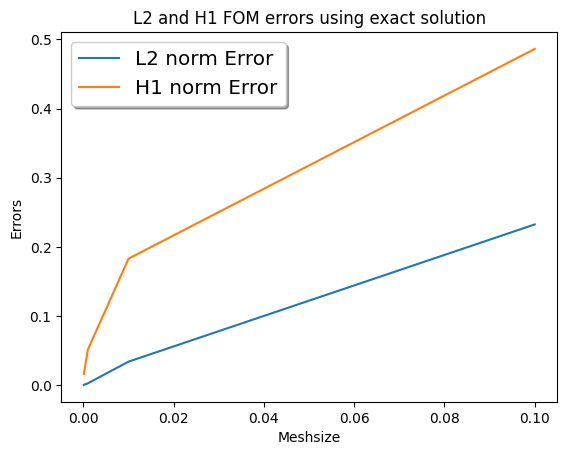

In [9]:
sizes = [0.1, 0.01, 0.001, 0.0001]
errorL2 = []
errorH1 = []

for size in sizes:
    # Build Mesh
    gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': size}, lib)
    problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0] # [0] to keep only the first output of Discretize function
    # FOM Solution
    [_, _, errorRelL2, errorRelH1] = fom(mu, lib, problemData, exactSol=True)
    errorL2.append(errorRelL2)
    errorH1.append(errorRelH1)

plt.clf()
x = sizes
y = errorL2
fig, ax = plt.subplots()
ax.plot(x, y, label='L2 norm Error')
y = errorH1
ax.plot(x, y, label='H1 norm Error')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("L2 and H1 FOM errors using exact solution")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_FOM.png")

# Order of convergence in L2 and H1 norm
pcoeffL2 = np.polyfit(np.log(x), np.log(errorL2), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(errorH1), 1)
# Slops for the two orders of convergence (m0 = 1 e m1 = 0,5)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("\nL2 Order:", orderL2, "- H1 Order:", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("Orders_FOM.csv")

# Since the POD algorithm converges, we can apply it in order to solve the problem with unknown solution

## 1.1 POD

### Parameters sampling
We start by defining the training set for the POD method obtained by uniformly sampling from the prameters' space $\mathcal{P}=[0.1,1]^2$

In [9]:
snapshotsCount = 300
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

### Snapshot matrix

We can now build the Snapshot matrix. The problem is not affine in the parameters so we need to assemble the Reaction matrix and the Nonlinear Forcing Term for each parametric instance

In [10]:
# Build Working Mesh
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0]

def buildSnapshotMatrix(problemData, trainingSet, exSolution=True):
    snapshotMatrix = []
    for mu in trainingSet:
        uK = fom(mu, lib, problemData, exactSol=exSolution)[0] # We keep only the first output uK
        snapshotMatrix.append(np.copy(uK))
    snapshotMatrix = np.array(snapshotMatrix)
    print(f'\nSnapshot Matrix dimension: {snapshotMatrix.shape}')
    return snapshotMatrix

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)

dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.5094415220396735e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.5094415220396735e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
71

### Covariance matrix 
We now build the Covariance Matrix. Inner product is mandatory since we are dealing with the Energy Norm and not the L2 one. This implies that the obtained basis won't be the best possible but an approximation

In [11]:
tol = 1. - 1e-7
NMax = 10

def covarianceMatrix(snapshotMatrix):
    innerProduct = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]
    
    C = snapshotMatrix @ innerProduct @ np.transpose(snapshotMatrix)
    
    # Compute eigenvalues and eigenvectors
    Le, VMe = np.linalg.eig(C)
    eigenvalues = []
    eigenvectors = []
    for i in range(len(Le)):
        eigReal = Le[i].real
        eigComplex = Le[i].imag
        assert np.isclose(eigComplex, 0.)
        eigenvalues.append(eigReal)
        eigenvectors.append(VMe[i].real)  
    totalEnergy = sum(eigenvalues)
    retainedEnergyVector = np.cumsum(eigenvalues)
    relativeRetainedEnergy = retainedEnergyVector / totalEnergy
    if all(flag == False for flag in relativeRetainedEnergy >= tol):
        N = NMax
    else:
        N = np.argmax(relativeRetainedEnergy >= tol) + 1
    print("The reduced dimension is:", N)
    print(relativeRetainedEnergy)
    return N, innerProduct, eigenvectors

[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

The reduced dimension is: 2
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Basis matrix
We are now able to build the basis functions and $\mathbb B$.

In [12]:
def buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors):
    basisFunctions = []
    for n in range(N):
        eigenvector = eigenvectors[n]
        basis = np.transpose(snapshotMatrix) @ eigenvector
        norm = np.sqrt(np.transpose(basis) @ innerProduct @ basis)
        basis = basis / norm
        basisFunctions.append(np.copy(basis))
    basisFunctions = np.transpose(np.array(basisFunctions))
    print(f'Basis functions dimension: {basisFunctions.shape}')
    return basisFunctions

basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

Basis functions dimension: (713, 2)


## 1.2 ROM

### Implement Newton algorithm and assemble the system

In [9]:
def rom(mu, lib, problemData, exactSol=True):
    residualNormPrj = 1.0
    solutionNormPrj = 1.0
    countIters = 1
    
    # Initial solution
    uKPrj = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')
    reducedUk = np.zeros(N, order='F')

    stiffness = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]

    # Forcing term given by the problem
    if exactSol:
        forcingTermExactG = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)  
    
    while countIters < maxIters and residualNormPrj > newtonTol * solutionNormPrj:
        reactionTerm = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uKPrj, uStrong, problemData, lib)[0]
        reactionTerm = mu[0] * reactionTerm
        
        # Diffusion and Nonlinear terms evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uKPrj, uStrong, problemData, lib)
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uKPrj, uStrong, problemData, lib)
        reducedStiffness = np.transpose(basisFunctions) @ stiffness @ basisFunctions
        reducedReaction = np.transpose(basisFunctions) @ reactionTerm @ basisFunctions

        if exactSol:
            reducedForcingTermExactG = np.transpose(basisFunctions) @ forcingTermExactG
        else:
            reducedForcingTermG = np.transpose(basisFunctions) @ forcingTermG
            
        reducedForcingTermDerV = np.transpose(basisFunctions) @ forcingTermDerV
        reducedForcingTermV = np.transpose(basisFunctions) @ forcingTermV

        # Reduced solution
        if exactSol:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermExactG - reducedForcingTermDerV - reducedForcingTermV, lib)
        else:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermG - reducedForcingTermDerV - reducedForcingTermV, lib)
        
        # Newton step
        reducedUk = reducedUk + reducedDu
        
        # Projection of reduced soution uK
        uKPrj = basisFunctions @ reducedUk 
        duPrj = basisFunctions @ reducedDu

        # Errors
        dUNormL2 = gedim.ComputeErrorL2(zeros, duPrj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uKPrj, uStrong, lib)
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uKPrj, uStrong, lib)

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uKPrj, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uKPrj, uStrong, lib)
        
        solutionNormPrj = uNormL2
        residualNormPrj = dUNormL2

        if exactSol:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))

        countIters = countIters + 1
    return uKPrj, uStrong

### Errors and Order of Convergence as a function of MeshSizes

dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329223e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718245e-01 4.8625662491747507e-01 4.9258543010461215e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237306685114831e-01 4.8625669401105714e-01 1.5113890739131797e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329223e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718245e-01 4.8625662491747507e-01 4.9258543010461215e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237306685114831e-01 4.8625669401105714e-01 1.5113890739131797e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000

<Figure size 640x480 with 0 Axes>

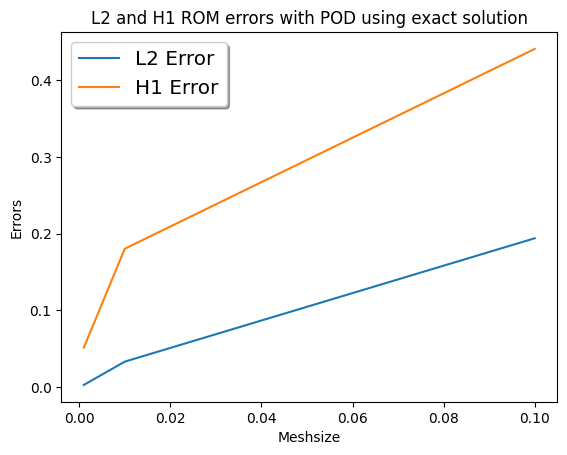

In [15]:
def errorExactVsRom(predPointsRom, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsRom, uStrong, lib)
    errorL2 = np.float64(0)
    errorH1 = np.float64(0)
    normL2Exact = 0
    normH1Exact = 0
    
    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2 = errorL2 + (quadWgts[q] * np.square(excSol - sol[q]))
        errorH1 = errorH1 + (quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q])))
        
        normL2Exact = normL2Exact + (quadWgts[q] * np.square(excSol))
        normH1Exact = normH1Exact + (quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1])))
    
    return np.sqrt(errorL2), np.sqrt(errorH1), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

#######################################################################################################################################################

snapshotsCount = 50
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))
errorL2Abs = []
errorH1Abs = []
errorL2Rel = []
errorH1Rel = []

for size in meshSizes:
    if size == 0.001:
        snapshotsCount = 25
    # Build Mesh
    gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': size}, lib)
    problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0]
    
    # Build Snapshot Matrix
    snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)

    # Build Covariance Matrix
    [N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

    # Compute Basis Functions
    basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)
    
    # ROM 
    [predPointsRom, uStrong] = rom(mu, lib, problemData, exactSol=True)
    
    # Errors
    [errorL2Rom, errorH1Rom, normL2Exact, normH1Exact] = errorExactVsRom(predPointsRom, uStrong)
    errorL2Abs.append(errorL2Rom)
    errorH1Abs.append(errorH1Rom)
    errorL2Rel.append(errorL2Rom / normL2Exact)
    errorH1Rel.append(errorH1Rom / normH1Exact)

#######################################################################################################################################################

plt.clf()
x = meshSizes
y = errorL2Rel
fig, ax = plt.subplots()
ax.plot(x, y, label='L2 Error')
y = errorH1Rel
ax.plot(x, y, label='H1 Error')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("L2 and H1 ROM errors with POD using exact solution")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_L2_H1_ROM.png")

pcoeffL2 = np.polyfit(np.log(x), np.log(errorL2Rel), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(errorH1Rel), 1)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("\nL2 Order:", orderL2, "H1 order:", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("Orders_ROM.csv")

### ROM VS FOM: Absolute and Relative Errors and SpeedUp

In [16]:
absoluteErrors = []
relativeErrors = []
testingSize = 50
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))
uKs = []
uKPrjs = []

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=True)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=True)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    error = uKs[i] - uKPrjs[i]
    errorNormSquared = np.transpose(error) @ innerProduct @ error
    absoluteError = np.sqrt(np.abs(errorNormSquared))
    absoluteErrors.append(absoluteError)

    fomNormSquared = np.transpose(uKs[i]) @ innerProduct @ uKs[i]
    relativeError = absoluteError / np.sqrt(np.abs(fomNormSquared))
    relativeErrors.append(relativeError)

print(f'\nAverage relative error: {np.mean(relativeErrors)}')
print(f'Average absolute error: {np.mean(absoluteErrors)}')
print(f'SpeedUp: {speedUp}')

dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 1.8363237541093233e-03 5.1306464210022565e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6847242126093987e-03 5.1349122725515325e-02 1.1013587472373776e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6847256289555953e-03 5.1349122807431404e-02 1.6728666788300907e-09 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 1.4338565568259591e-03 5.1289310718960326e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6607845591673698e-03 5.1347746874952069e-02 1.9475097422122902e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6607921529358150e-03 5.1347747310884789e-02 8.9955371724701865e-09 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
71

### Plot ROM solution

dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 3.7314869837226793e-03 5.1385656359209504e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.7253686360354645e-03 5.1351488702528744e-02 5.9290254878985298e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6925244694824247e-03 5.1349577041234946e-02 3.7204830290790506e-05 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6927301294544870e-03 5.1349588948473912e-02 2.3338300373019317e-07 4 25


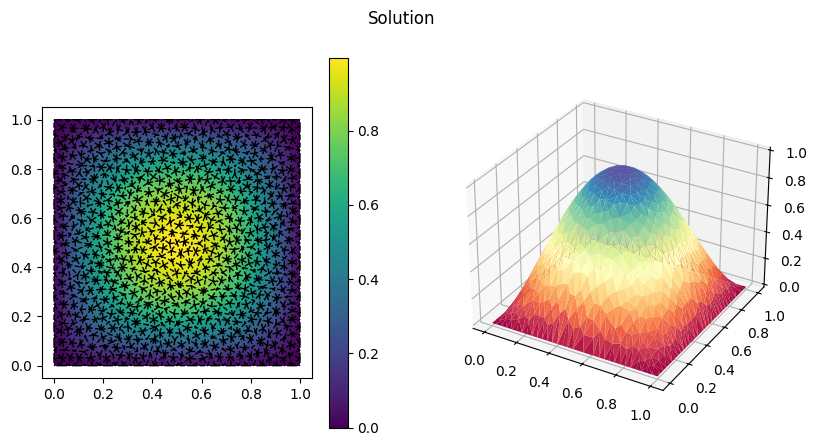

In [17]:
[uK, uStrong] = rom(mu, lib, problemData, exactSol=True)

gedim.PlotSolution(mesh, dofs, strongs, uK, uStrong)

# 2 POD without exact solution
We now numerically find the unknown solution of the nonlinear elliptic problem with the forcing term given by 
$$
g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
$$

### Snapshot matrix 

In [20]:
snapshotsCount = 300
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

# Build Working Mesh
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]}, lib)[0]

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet, exSolution=False)

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.0554912940641259e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.3753042955149872e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.0554912940641259e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.3753042955149872e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.0554912940641259e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.3753042955149872e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Covariance matrix

In [21]:
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

The reduced dimension is: 2
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Basis matrix

In [22]:
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

Basis functions dimension: (713, 2)


### ROM: Errors and SpeedUp

In [23]:
absError = []
relError = []
uKs = []
uKPrjs = []
testingSize = 20
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    error = uKs[i] - uKPrjs[i]
    errorNormSquared = np.transpose(error) @ innerProduct @ error
    absoluteError = np.sqrt(np.abs(errorNormSquared))
    absError.append(absoluteError)

    fomNormSquared = np.transpose(uKs[i]) @ innerProduct @ uKs[i]
    relativeError = absoluteError / np.sqrt(np.abs(fomNormSquared))
    relError.append(relativeError)
print(f'\nAverage Relative error: {np.mean(relError)}') # 2 ordini in meno
print(f'Average Absolute error: {np.mean(absError)}')
print(f'SpeedUp: {speedUp}')

pd.DataFrame({'Relative_FOMvsROM': [np.mean(relError)], 'Absolute_FOMvsROM': [np.mean(absError)], 'SpeedUp_POD': [speedUp]}).to_csv("POD.csv")

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.7811212236646044e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.2279044115072523e-07 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 4.0833524951443979e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 8.8458448683348166e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.2310399139424242e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.3314903543778555e-07 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Errors on quadrature points

In [29]:
def errorFomVsRom(pointsRom, pointsFom, uStrong):
    [numQuadraturePoints, _, quadratureWeights, solRom, solXRom, solYRom] = gedim.EvaluateSolutionOnPoints(pointsRom, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(pointsFom, uStrong, lib)
    errorL2Rom = np.float64(0)
    errorH1Rom = np.float64(0)
    normL2Fom = np.float64(0)
    normH1Fom = np.float64(0)
    
    for q in range(numQuadraturePoints):
        errorL2Rom = errorL2Rom + (quadratureWeights[q] * np.square(solFom[q] - solRom[q]))
        errorH1Rom = errorH1Rom + (quadratureWeights[q] * (np.square(solXFom[q] - solXRom[q]) + np.square(solYFom[q] - solYRom[q])))
        
        normL2Fom = normL2Fom + (quadratureWeights[q] * np.square(solFom[q]))
        normH1Fom = normH1Fom + (quadratureWeights[q] * (np.square(solXFom[q]) + np.square(solYFom[q])))
    
    return np.sqrt(errorL2Rom), np.sqrt(errorH1Rom), np.sqrt(normL2Fom), np.sqrt(normH1Fom)

###################################################################################################################################################

absErrorL2 = []
relErrorL2 = []
absErrorH1 = []
relErrorH1 = []
uKs = []
uKPrjs = []
testingSize = 20
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    [errorL2ROMvsFOM, errorH1ROMvsFOM, normL2Fom, normH1Fom] = errorFomVsRom(uKPrjs[i], uKs[i], np.zeros(problemData['NumberStrongs'], order='F'))
    absErrorL2.append(errorL2ROMvsFOM)
    absErrorH1.append(errorH1ROMvsFOM)
    relErrorL2.append(errorL2ROMvsFOM / normL2Fom)
    relErrorH1.append(errorH1ROMvsFOM / normH1Fom)

print(f'\nH1 Relative Error ROM vs FOM: {np.mean(relErrorH1)}')
print(f'L2 Relative Error ROM vs FOM: {np.mean(relErrorL2)}')
print(f'SpeedUp: {speedUp}')

pd.DataFrame({'RelativeL2_FOMvsROM': [np.mean(relErrorL2)],'AbsoluteL2_FOMvsROM': [np.mean(absErrorL2)],'RelativeH1_FOMvsROM': [np.mean(relErrorH1)], 'AbsoluteH1_FOMvsROM': [np.mean(absErrorH1)], 'SpeedUp_POD': [speedUp]}).to_csv("PODquadratures.csv")

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.7152804900793296e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.6184686250392007e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.4794182041786019e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 4.0258665158890233e-09 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.8828090033479331e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.1140383391834570e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Plot Solution

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.7866047445097866e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.5546861142167957e-05 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.3832400373686949e-08 4 25


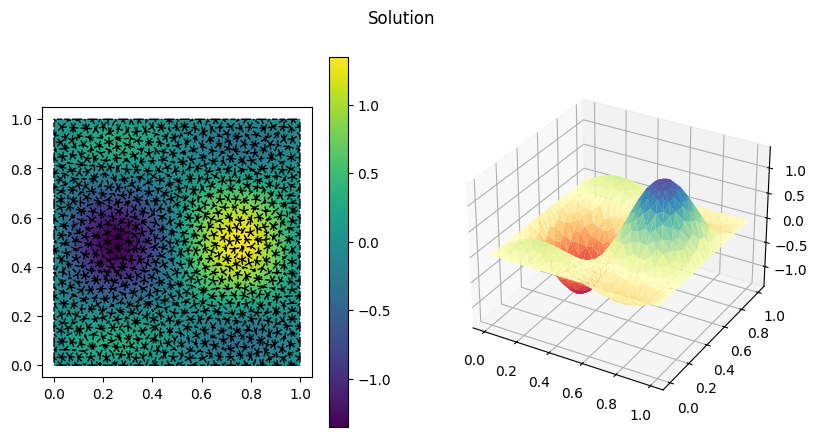

In [31]:
[uKPrj, uStrong] = rom(mu, lib, problemData, exactSol=False)

gedim.PlotSolution(mesh, dofs, strongs, uKPrj, uStrong)

gedim.ExportSolution(exactSolution, uKPrj, uStrong, lib)

# 3 Parametric PINN

### PINN parameters

In [33]:
# Set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Training set size
size = 1000

# Training parameters
coefficient = 2750
learningRate = 0.01
iterations = 20000

## Network

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(4, 7) # 4 inputs = x0, x1, mu0, mu1

        self.hidden_layer1 = nn.Linear(7, 7) # n[input] + m[output] + 2 = 7 neurons per layer [from UAT-2]
        self.hidden_layer2 = nn.Linear(7, 7)
        self.hidden_layer3 = nn.Linear(7, 7)
        self.hidden_layer4 = nn.Linear(7, 7)
        
        self.output_layer = nn.Linear(7, 1) # 1 output = u [scalar]

    def forward(self, x0, x1, mu0, mu1):
        input = torch.cat([x0, x1, mu0, mu1], axis=1) # combines the column array
        
        layer1output = torch.sigmoid(self.input_layer(input))
        layer2output = torch.sigmoid(self.hidden_layer1(layer1output))
        layer3output = torch.sigmoid(self.hidden_layer2(layer2output))
        layer4output = torch.sigmoid(self.hidden_layer3(layer3output))
        layer5output = torch.sigmoid(self.hidden_layer4(layer4output))
        
        output = self.output_layer(layer5output)
        return output

### Residual function (PDE as the Loss function)

In [35]:
def R(x0, x1, mu0, mu1, net, exactSol=False):
    u = net(x0, x1, mu0 , mu1) # prediction
    u_x0 = torch.autograd.grad(u.sum(), x0, create_graph=True)[0] # derivative of u over x0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x0, create_graph=True)[0] # second derivative of u over x0
    u_x1 = torch.autograd.grad(u.sum(), x1, create_graph=True)[0] # derivative of u over x1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x1, create_graph=True)[0] # second derivative of u over x1
    u_xx = u_xx0 + u_xx1

    if exactSol:
        g = torch.Tensor(32.0 * (x1.detach().numpy() * (1.0 - x1.detach().numpy()) + x0.detach().numpy() * (1.0 - x0.detach().numpy())) + \
                      	 +  mu0.detach().numpy() / mu1.detach().numpy() * (np.exp(mu1.detach().numpy() * 16 * x0.detach().numpy() * x1.detach().numpy() * \
                         (1.0 - x0.detach().numpy()) * (1.0 - x1.detach().numpy())) - 1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x0.detach().numpy()) * np.cos(2 * np.pi * x1.detach().numpy()))
    
    fNoLin = mu0 / mu1 * (torch.exp(mu1 * u) - 1)
    pde = - u_xx + fNoLin - g
    return pde

### Training set

In [36]:
# Border's training set
x0Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
x1Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
allZeros = np.zeros((size, 1))
allOnes = np.ones((size, 1))
lx0 = np.concatenate([x0Bc, allOnes, x0Bc, allZeros], axis=0)
lx1 = np.concatenate([allZeros, x1Bc, allOnes, x1Bc], axis=0)

# Boundary conditions for u
uBc = np.zeros((size * 4, 1))

# Parameters' training set
trainingSetMu0 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))
trainingSetMu1 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))

# Interior points' training set
x0Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))
x1Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))

## 3.1 PINN with exact solution
As done for the POD, firstly we solve the problem by means of PINN method choosing the exact solution
\begin{equation*}
    u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1 - x_0)(1 - x_1)
\end{equation*}
using which we get the corresponding right hand side
$$
\begin{align*}
    g_{ex}(\mathbf{x};\mathbf{\mu}) &= -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})} - 1\right) \\
    &= 32x_0(1 - x_0) + 32x_1(1 - x_1)+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
\end{align*}
$$

### Offline phase - Training

In [37]:
def training(iterations, net, mse, coefficient, optimizer, lx0, lx1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc):
    trainingLosses = []
    for epoch in range(iterations):
        optimizer.zero_grad()
    
        # Loss on boundary conditions
        ptX0Bc = Variable(torch.from_numpy(lx0).float(), requires_grad=False)
        ptX1Bc = Variable(torch.from_numpy(lx1).float(), requires_grad=False)
        mu0Tensor = Variable(torch.from_numpy(trainingSetMu0).float(), requires_grad=False)
        mu1Tensor = Variable(torch.from_numpy(trainingSetMu1).float(), requires_grad=False)
        # Homogeneous Dirichlet BC
        ptUbc = Variable(torch.from_numpy(uBc).float(), requires_grad=False)
        # Net output
        netBcOutput = net(ptX0Bc, ptX1Bc, mu0Tensor, mu1Tensor)
        # MSE over u(x)
        mseU = mse(netBcOutput, ptUbc)
        # Loss based on PDE
        allZeros = np.zeros((size * 4, 1))
        
        # Loss on interior points
        ptX0Collocation = Variable(torch.from_numpy(x0Int).float(), requires_grad=True)
        ptX1Collocation = Variable(torch.from_numpy(x1Int).float(), requires_grad=True)
        ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False)
        # Residuals
        residuals = R(ptX0Collocation, ptX1Collocation, mu0Tensor, mu1Tensor, net, True)
        # MSE over residuals
        mseF = mse(residuals, ptAllZeros)
        
        # Combining the loss functions
        loss = mseF + coefficient * mseU
        loss.backward() 
        optimizer.step()

        with torch.autograd.no_grad():
            if epoch % 100 == 0:
                print(epoch,"Loss:",loss.item())
        trainingLosses.append(loss.item())
    return net, trainingLosses

0 Loss: 244.9825439453125
100 Loss: 132.9019317626953
200 Loss: 132.90032958984375
300 Loss: 132.9002685546875
400 Loss: 132.8997802734375
500 Loss: 132.89060974121094
600 Loss: 132.18685913085938
700 Loss: 78.05658721923828
800 Loss: 23.437801361083984
900 Loss: 18.092437744140625
1000 Loss: 13.443401336669922
1100 Loss: 9.66402816772461
1200 Loss: 7.05058479309082
1300 Loss: 5.906866073608398
1400 Loss: 5.02181339263916
1500 Loss: 4.4723076820373535
1600 Loss: 3.8968515396118164
1700 Loss: 3.5402116775512695
1800 Loss: 3.2500123977661133
1900 Loss: 3.1009507179260254
2000 Loss: 2.9126129150390625
2100 Loss: 3.654707431793213
2200 Loss: 2.698047399520874
2300 Loss: 2.608273983001709
2400 Loss: 2.5430121421813965
2500 Loss: 2.470609664916992
2600 Loss: 3.5599818229675293
2700 Loss: 2.355396032333374
2800 Loss: 2.3104031085968018
2900 Loss: 2.2608683109283447
3000 Loss: 2.2173805236816406
3100 Loss: 2.1813719272613525
3200 Loss: 2.145050048828125
3300 Loss: 2.117356061935425
3400 Loss: 

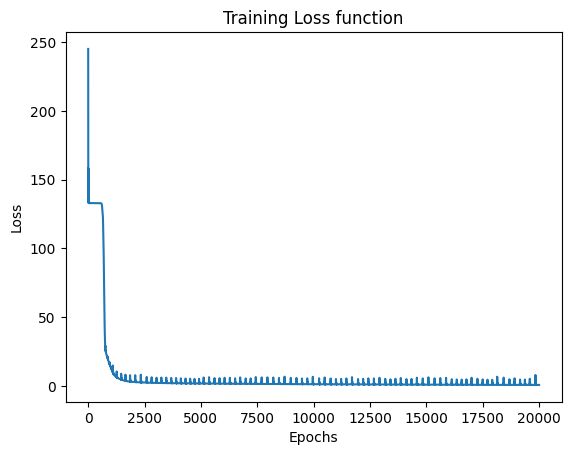

In [38]:
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

[net, trainingLoss] = training(iterations, net, mse, coefficient, optimizer, lx0, lx1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc)

PATH = "modelExactSolution.pth"
torch.save(net.state_dict(), PATH)

plt.clf()
plt.plot(range(iterations), trainingLoss)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss_exactsolution.png')

### Online phase - Predict

In [39]:
# Build working mesh
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# Build needed tensors
x0Bc = strongs[0].reshape(-1, 1)
x1Bc = strongs[1].reshape(-1, 1)
x0BcTensor = Variable(torch.from_numpy(x0Bc).float(), requires_grad=False) # To tensor
x1BcTensor = Variable(torch.from_numpy(x1Bc).float(), requires_grad=False)

x0 = dofs[0].reshape(-1, 1)
x1 = dofs[1].reshape(-1, 1)
x0Tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True) # To tensor
x1Tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1Tensor.size(0), 1)
mu0BcTensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0BcTensor.size(0), 1)
mu1BcTensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1BcTensor.size(0), 1)

In [40]:
def predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=False): 
    allZeros = np.zeros((x1Tensor.shape[0], 1))
    ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False) # We want zero residual
    uPredicted = net(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor)
    
    u_x0 = torch.autograd.grad(uPredicted.sum(), x0Tensor, create_graph=True)[0]
    u_xx0 = torch.autograd.grad(u_x0.sum(), x0Tensor, create_graph=True)[0]
    u_x1 = torch.autograd.grad(uPredicted.sum(), x1Tensor, create_graph=True)[0]
    u_xx1 = torch.autograd.grad(u_x1.sum(), x1Tensor, create_graph=True)[0]
    u_xx = u_xx0 + u_xx1

    if exact:
        g = torch.Tensor(32.0 * (x1Tensor.detach().numpy() * (1.0 - x1Tensor.detach().numpy()) + x0Tensor.detach().numpy() * (1.0 - x0Tensor.detach().numpy())) + \
                             +  mu0Tensor.detach().numpy() / mu1Tensor.detach().numpy() * (np.exp(mu1Tensor.detach().numpy() * 16 * x0Tensor.detach().numpy() * x1Tensor.detach().numpy() * \
                            (1.0 - x0Tensor.detach().numpy()) * (1.0 - x1Tensor.detach().numpy())) - 1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x0Tensor.detach().numpy()) * np.cos(2 * np.pi * x1Tensor.detach().numpy()))
    
    fNonLinear = mu0Tensor / mu1Tensor * (torch.exp(mu1Tensor * uPredicted) - 1)
    pde = - u_xx + fNonLinear - g
    mseF = mse(pde, ptAllZeros)
    
    return uPredicted, mseF

In [41]:
# Evaluate pretrained model
PATH = "modelExactSolution.pth"
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
net.load_state_dict(torch.load(PATH, weights_only=True))

predPoints = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=True)[0]

### H1 and L2 errors

In [42]:
def errorPINN(predPointsRom, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsRom, uStrong, lib)
    errorL2PINN = np.float64(0)
    errorH1PINN = np.float64(0)
    normL2Exact = np.float64(0)
    normH1Exact = np.float64(0)

    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2PINN = errorL2PINN + (quadWgts[q] * np.square(excSol - sol[q]))
        errorH1PINN = errorH1PINN + (quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q])))
        
        normL2Exact = normL2Exact + (quadWgts[q] * np.square(excSol))
        normH1Exact = normH1Exact + (quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1])))
    
    return np.sqrt(errorL2PINN), np.sqrt(errorH1PINN), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

############################################################################################################################

predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

[errorL2PINN, errorH1PINN, normL2Exact, normH1Exact] = errorPINN(predPoints, uStrong)

print(f'Absolute L2 error: {errorL2PINN}')
print(f'Absolute H1 error: {errorH1PINN}')
print(f'Relative L2 error: {(errorL2PINN / normL2Exact)}')
print(f'Relative H1 error: {(errorH1PINN / normH1Exact)}')

Absolute L2 error: 0.0034908540415950853
Absolute H1 error: 0.1438119890684055
Relative L2 error: 0.006545352534655507
Relative H1 error: 0.06029501554677571


### SpeedUp of PINN vs FOM

In [43]:
def timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net):
    # 100 predictions
    startTime = time.time()
    for _ in range(100):
        predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=True)
    meanTime = (time.time() - startTime) / 100
    print(f'Mean PINN prediction time: ', meanTime)
    return meanTime

numSnapshots = 100
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(numSnapshots, P.shape[0]))

# Build Mesh
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# FOM
fomTime = time.time()
for mu in testingSet:
    fom(mu, lib, problemData, exactSol=True)
fomTime = time.time() - fomTime
meanFomTime = fomTime / numSnapshots

# POD & ROM
# snapshotMatrix = buildSnapshotMatrix(problemData, testingSet)
# [N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
# basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)
# romTime = time.time()
# for mu in testingSet:
#     rom(mu, lib, problemData, exactSol=True)
# romTime = time.time() - romTime
# meanRomTime = romTime / numSnapshots

# PINN
meanTimePINN = timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)

# SpeedU
speedUpFomVsPINN = meanFomTime / meanTimePINN
print(f'SpeedUp FOM vs PINN: {speedUpFomVsPINN}')

dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4836976396789617e-03 5.1441177697689709e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6137441807417496e-03 5.1345073276672801e-02 6.4947439570725487e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6140545904731111e-03 5.1345090835055833e-02 3.7096562116579271e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 6.7049953998407396e-03 5.1670415754733412e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6183648983937316e-03 5.1345332505855656e-02 8.8243965621974223e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6192702233434244e-03 5.1345383789939518e-02 1.0839453959191054e-06 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
71

### Plot exact solution

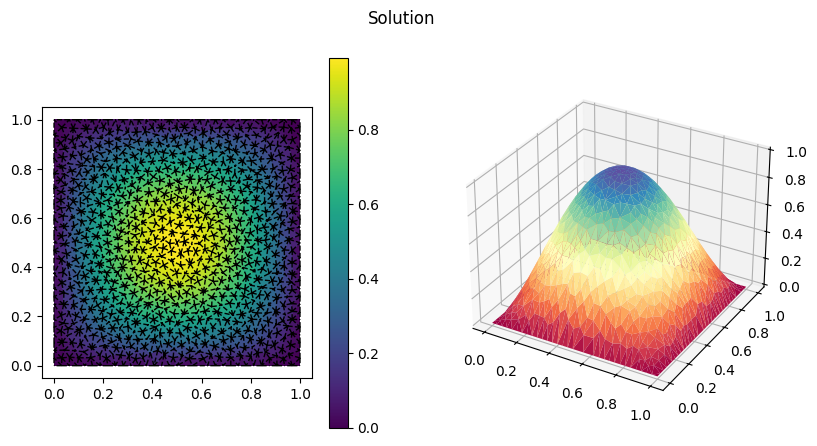

In [44]:
gedim.PlotSolution(mesh, dofs, strongs, predPoints, uStrong)

gedim.ExportSolution(exactSolution, predPoints, uStrong, lib)

## 3.2 PINN without exact solution
We now find an approximation of the unknown solution of our problem with forcing term
\begin{equation*}
    g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
\end{equation*}

### PINN parameters

In [135]:
size = 1000

coefficient = 2750
iterations = 25000

### Offline phase - Training

In [136]:
# Boundaries' training set
x0Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
x1Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
allZeros = np.zeros((size, 1))
allOnes = np.ones((size, 1))
lX0 = np.concatenate([x0Bc, allOnes, x0Bc, allZeros], axis=0)
lX1 = np.concatenate([allZeros, x1Bc, allOnes, x1Bc], axis=0)

# Boundary conditions for u
uBc = np.zeros((size * 4, 1))

# Parameters' training set
trainingSetMu0 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))
trainingSetMu1 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))

# Interior points' training set
x0Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))
x1Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))

In [137]:
def training(iterations, net, mse, optimizer, lX0, lX1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc):
    trainingLoss = []
    for epoch in range(iterations):
        optimizer.zero_grad()

        # Loss based on boundary conditions
        ptX0Bc = Variable(torch.from_numpy(lX0).float(), requires_grad=False)
        ptX1Bc = Variable(torch.from_numpy(lX1).float(), requires_grad=False)
        mu0Tensor = Variable(torch.from_numpy(trainingSetMu0).float(), requires_grad=False)
        mu1Tensor = Variable(torch.from_numpy(trainingSetMu1).float(), requires_grad=False)
        # Homogeneous Dirichlet bc
        ptuBc = Variable(torch.from_numpy(uBc).float(), requires_grad=False)
        bcOutput = net(ptX0Bc, ptX1Bc, mu0Tensor, mu1Tensor) # output of u(x)
        mseU = mse(bcOutput, ptuBc)
        
        # Residual loss
        allZeros = np.zeros((size * 4, 1))
        ptX0Collocation = Variable(torch.from_numpy(x0Int).float(), requires_grad=True)
        ptX1Collocation = Variable(torch.from_numpy(x1Int).float(), requires_grad=True)
        ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False) # We want a zero residual
        fOutput = R(ptX0Collocation, ptX1Collocation, mu0Tensor, mu1Tensor, net) # Residuals
        mseF = mse(fOutput, ptAllZeros)
        
        # Combining loss functions
        loss = mseF + coefficient * mseU
        loss.backward() 
        optimizer.step()
        
        with torch.autograd.no_grad():
            if epoch % 1000 == 0:
                print(epoch, "Loss:", loss.item())
        trainingLoss.append(loss.item())
    return net, trainingLoss

0 Loss: 3282.05517578125
1000 Loss: 2508.298095703125
2000 Loss: 2508.2978515625
3000 Loss: 2508.2978515625
4000 Loss: 2508.2978515625
5000 Loss: 2508.2978515625
6000 Loss: 1020.166259765625
7000 Loss: 70.52391815185547
8000 Loss: 67.48384094238281
9000 Loss: 32.324886322021484
10000 Loss: 27.571718215942383
11000 Loss: 24.240211486816406
12000 Loss: 21.74868392944336
13000 Loss: 19.73324203491211
14000 Loss: 18.040287017822266
15000 Loss: 16.46089744567871
16000 Loss: 15.440057754516602
17000 Loss: 13.650971412658691
18000 Loss: 12.461576461791992
19000 Loss: 25.199390411376953
20000 Loss: 10.386370658874512
21000 Loss: 9.552084922790527
22000 Loss: 8.800761222839355
23000 Loss: 8.219528198242188
24000 Loss: 7.745102882385254


<Figure size 640x480 with 0 Axes>

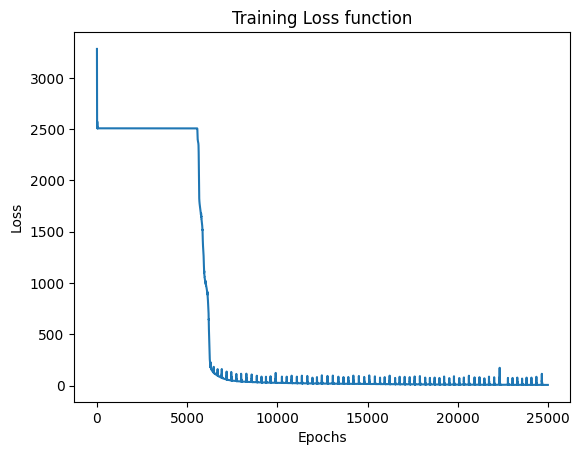

In [138]:
PATH = "modelUnknownSolution.pth"
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

[net, trainingLosses] = training(iterations, net, mse, optimizer, lX0, lX1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc)
torch.save(net.state_dict(), PATH)

plt.clf()
plt.figure()
plt.plot(range(len(trainingLosses)), trainingLosses)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss_unknownsolution.png')

### Online phase - Prediction

In [220]:
# Evaluate pretrained model
net.load_state_dict(torch.load(PATH, weights_only=True))

# Interior points' test set
x0 = dofs[0].reshape(-1, 1)
x1 = dofs[1].reshape(-1, 1)
x0Tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True) # To tensor
x1Tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)
mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1Tensor.size(0), 1)

predictedPoints = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=False)[0]
predictedPoints = predictedPoints.data.cpu().numpy().astype(np.float64).reshape(-1)

### Errors and SpeedUp of PINN vs FOM and POD

In [221]:
def errorPinnVsFom(predPointsPinn, predPointsFom, uStrong):
    [numQuadPts, _, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsPinn, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(predPointsFom, uStrong, lib)
    errorL2PINN = np.float64(0)
    errorH1PINN = np.float64(0)
    normL2Exact = np.float64(0)
    normH1Exact = np.float64(0)
    
    for q in range(numQuadPts):
        errorL2PINN = errorL2PINN + (quadWgts[q] * np.square(solFom[q] - sol[q]))
        errorH1PINN = errorH1PINN + (quadWgts[q] * (np.square(solXFom[q] - solX[q]) + np.square(solYFom[q] - solY[q])))
        
        normL2Exact = normL2Exact + (quadWgts[q] * np.square(solFom[q]))
        normH1Exact = normH1Exact + (quadWgts[q] * (np.square(solXFom[q]) + np.square(solYFom[q])))
    
    return np.sqrt(errorL2PINN), np.sqrt(errorH1PINN), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

In [224]:
# Build Mesh
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

absoluteErrorL2 = []
relativeErrorL2 = []
absoluteErrorH1 = []
relativeErrorH1 = []
uKs = []

testingSize = 100
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime
meanTimeFom = fomTime / testingSize

meanTimePINN = timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)

speedUpFomVsPINN = meanTimeFom / meanTimePINN

for uK in uKs:
    [errorL2PinnVsFom, errorH1PinnVsFom, normL2Fom, normH1Fom] = errorPinnVsFom(predictedPoints, uK, uStrong)
    absoluteErrorL2.append(errorL2PinnVsFom)
    absoluteErrorH1.append(errorH1PinnVsFom)
    relativeErrorL2.append(errorL2PinnVsFom / normL2Fom)
    relativeErrorH1.append(errorH1PinnVsFom / normH1Fom)

print(f'Absolute L2 error: {np.mean(absoluteErrorL2)}')
print(f'Absolute H1 error: {np.mean(absoluteErrorH1)}')
print(f'Relative L2 error: {np.mean(relativeErrorL2)}')
print(f'Relative H1 error: {np.mean(relativeErrorH1)}')
print(f'SpeedUp PINN vs FOM: {speedUpFomVsPINN}')

pd.DataFrame({'RelativeL2_FOMvsPINN': [np.mean(relativeErrorL2)], 'AbsoluteL2_FOMvsPINN': [np.mean(absoluteErrorL2)], 'RelativeH1_FOMvsPINN': [np.mean(relativeErrorH1)], 'AbsoluteH1_FOMvsPINN': [np.mean(absoluteErrorH1)], 'SpeedUp_PINN': [np.mean(speedUpFomVsPINN)]}).to_csv("PINNquadratures.csv")

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0179297921236202e-02 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.7429228460377221e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.6108472410305120e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.8988846920252976e-07 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.2582110856891758e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.3862182772207300e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Plot solution

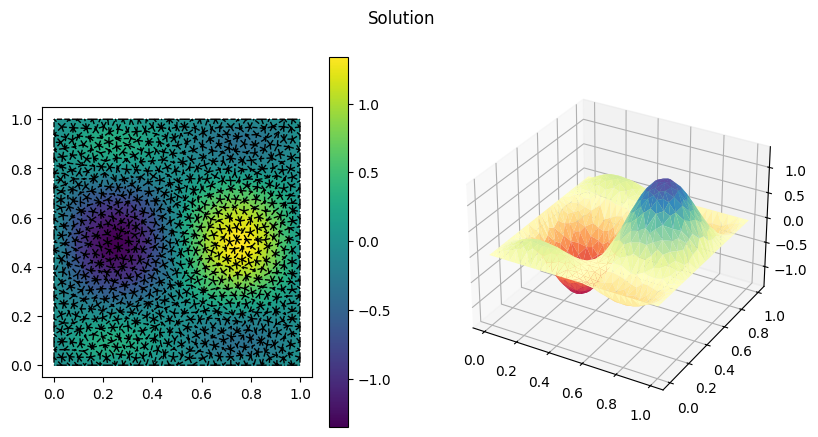

In [225]:
predPoints = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)[0]
predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)

gedim.PlotSolution(mesh, dofs, strongs, predPoints, uStrong)

gedim.ExportSolution(exactSolution, predPoints, uStrong, lib)

# 4 POD-nn

## 4.1 POD-nn with exact solution
Firstly we solve the problem choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1 - x_0)(1 - x_1)$ and the respective right hand side
\begin{equation*}
    g_{ex}(\mathbf{x};\mathbf{\mu}) = 32x_0(1 - x_0) + 32x_1(1 - x_1) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1 - x_0)(1 - x_1)} - 1\right)
\end{equation*}

### Network parameters

In [67]:
learningRate = 0.001
maxEpoches = 20000
tolerance = 1e-6

seed = 31
torch.manual_seed(seed)

### Offline phase - build reduced space

In [68]:
def buildSnapshotMatrix(problemData, trainingSet, exSolution=True):
    snapshotMatrix = []
    for mu in trainingSet:
        uK = fom(mu, lib, problemData, exactSol=exSolution)[0]
        snapshotMatrix.append(np.copy(uK))
    snapshotMatrix = np.array(snapshotMatrix)
    print(f'\nSnapshot Matrix dimension: {snapshotMatrix.shape}')
    return snapshotMatrix

def covarianceMatrix(snapshotMatrix):
    tol = 1. - 1e-7
    NMax = 10
    innerProduct = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]
    C = snapshotMatrix @ innerProduct @ np.transpose(snapshotMatrix)
    Le, VMe = np.linalg.eig(C)
    eigenvalues = []
    eigenvectors = []
    for i in range(len(Le)):
        eigReal = Le[i].real
        eigComplex = Le[i].imag
        assert np.isclose(eigComplex, 0.)
        eigenvalues.append(eigReal)
        eigenvectors.append(VMe[i].real)  
    totalEnergy = sum(eigenvalues)
    retainedEnergyVector = np.cumsum(eigenvalues)
    relativeRetainedEnergy = retainedEnergyVector / totalEnergy
    if all(flag == False for flag in relativeRetainedEnergy >= tol):
        N = NMax
    else:
        N = np.argmax(relativeRetainedEnergy >= tol) + 1
    print("The reduced dimension is:", N)
    print(relativeRetainedEnergy)
    return N, innerProduct, eigenvectors

def buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors):
    basisFunctions = []
    for n in range(N):
        eigenvector = eigenvectors[n]
        basis = np.transpose(snapshotMatrix) @ eigenvector
        norm = np.sqrt(np.transpose(basis) @ innerProduct @ basis)
        basis = basis / norm
        basisFunctions.append(np.copy(basis))
    basisFunctions = np.transpose(np.array(basisFunctions))
    print(f'Basis functions dimension: {basisFunctions.shape}')
    return basisFunctions

In [34]:
snapshotsCount = 300
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.5094415220396735e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 25
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.5094415220396735e-07 3 25
dofs h errorL2 errorH1 residual iteration max_iteration
71

### Offline phase - network

In [85]:
basisDimension = N # Reduced space's dim
inputDimension = P.shape[0] # Parameter space's dim
outputDimension = basisDimension
nodes = 30 # number of nodes inside

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(inputDimension, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, outputDimension)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)

### Offline phase - training

In [86]:
reducedInnerProduct = np.transpose(basisFunctions) @ innerProduct @ basisFunctions
xTrain = torch.tensor(np.float32(trainingSet))
yTrain = []
for i in range(snapshotMatrix.shape[0]):
    snapshot = snapshotMatrix[i]
    # We solve the system: X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)
    projectedSnapshot = np.linalg.solve(reducedInnerProduct, np.transpose(basisFunctions) @ innerProduct @ snapshot)
    yTrain.append(projectedSnapshot)
yTrain = torch.tensor(np.float32(yTrain))

In [87]:
epoch = 0
loss = 1.0
while loss >= tolerance and epoch < maxEpoches:
    epoch = epoch + 1
    optimizer.zero_grad()
    output = net(xTrain)
    loss = mse(output, yTrain)
    if epoch >= 10000:
        optimizer.param_groups[0]['lr'] = 0.0001
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'])

PATH = "modelExactSolutionPODNN.pth"
torch.save(net.state_dict(), PATH)
net.load_state_dict(torch.load(PATH, weights_only=True))

epoch 500 loss 3.3644912036834285e-05 lr 0.001
epoch 1000 loss 3.1638654036214575e-05 lr 0.001
epoch 1500 loss 2.900407707784325e-05 lr 0.001
epoch 2000 loss 2.5941322746803053e-05 lr 0.001
epoch 2500 loss 2.263497663079761e-05 lr 0.001
epoch 3000 loss 1.92592397070257e-05 lr 0.001
epoch 3500 loss 1.596853144292254e-05 lr 0.001
epoch 4000 loss 1.2885133401141502e-05 lr 0.001
epoch 4500 loss 1.0096628102473915e-05 lr 0.001
epoch 5000 loss 7.654680302948691e-06 lr 0.001
epoch 5500 loss 5.581181994784856e-06 lr 0.001
epoch 6000 loss 3.880968051817035e-06 lr 0.001
epoch 6500 loss 2.5505169105599634e-06 lr 0.001
epoch 7000 loss 1.5847958820813801e-06 lr 0.001


<All keys matched successfully>

### Online phase - Prediction

In [88]:
def predictPODNN(nnInput, net):
    nnInput = torch.tensor(np.float32(nnInput))
    reducedSolution = np.asarray(net(nnInput).detach().numpy())[0] # Tensor to array
    uPrj = basisFunctions @ reducedSolution # Solution in the high fidelity setting
    return uPrj

# Compute solution
uPrj = predictPODNN([mu], net)

### Absolute - Relative and H1 - L2 errors

In [89]:
def errorExactVsPodnn(predPointsPodnn, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsPodnn, uStrong, lib)
    errorL2 = np.float64(0)
    errorH1 = np.float64(0)
    normL2Exact = np.float64(0)
    normH1Exact = np.float64(0)
    
    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2 = errorL2 + (quadWgts[q] * np.square(excSol - sol[q]))
        errorH1 = errorH1 + (quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q])))
        
        normL2Exact = normL2Exact + (quadWgts[q] * np.square(excSol))
        normH1Exact = normH1Exact + (quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1])))
    
    return np.sqrt(errorL2), np.sqrt(errorH1), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

def timePodnn(testingSet, net):
    startTime = time.time()
    for mu in testingSet:
        predictPODNN([mu], net)
    meanTime = (time.time() - startTime) / len(testingSet)
    print(f'Mean PODNN prediction time:', meanTime)
    return meanTime

#######################################################################################################################

absoluteErrors = []
relativeErrors = []
absoluteErrorL2 = []
absoluteErrorH1 = []
relativeErrorL2 = []
relativeErrorH1 = []
fomSolutions = []

testingSize = 100
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

# FOM
fomTime = time.time()
for mu in testingSet:
    fomSolutions.append(fom(mu, lib, problemData, exactSol=False)[0])
fomTime = time.time() - fomTime
meanTimeFom = fomTime / testingSize

# SpeedUp
meanTimePodnn = timePodnn(testingSet, net)
speedUpPodnn = meanTimeFom / meanTimePodnn

# Relative and absolute errors
for i in range(len(fomSolutions)):
    error = fomSolutions[i] - predictPODNN([testingSet[i]], net)
    errorNormSquared = np.transpose(error) @ innerProduct @ error
    absoluteError = np.sqrt(np.abs(errorNormSquared))
    absoluteErrors.append(absoluteError)

    fomNormSquared = np.transpose(fomSolutions[i]) @ innerProduct @ fomSolutions[i]
    relativeError = absoluteError / np.sqrt(np.abs(fomNormSquared))
    relativeErrors.append(relativeError)
print(f'\nAverage relative error: {np.mean(relativeErrors)}')
print(f'Average absolute error: {np.mean(absoluteErrors)}')

# H1 and L2 errors
for i in range(len(testingSet)):
    uPrj = predictPODNN([testingSet[i]], net)
    [errorL2Podnn, errorH1Podnn, normL2, normH1] = errorExactVsPodnn(uPrj, uStrong)
    absoluteErrorL2.append(errorL2Podnn)
    absoluteErrorH1.append(errorH1Podnn)
    relativeErrorL2.append(errorL2Podnn / normL2)
    relativeErrorH1.append(errorH1Podnn / normH1)
print("\nAverage Relative L2 error:", np.mean(relativeErrorL2))
print("Average Absolute L2 error:", np.mean(absoluteErrorL2))
print("Average Relative H1 error:", np.mean(relativeErrorH1))
print("Average Absolute H1 error:", np.mean(absoluteErrorH1))
print("SpeedUp:", speedUpPodnn)

pd.DataFrame({'RelativeL2_FOMvsPODNN': [np.mean(relativeErrorL2)], 'AbsoluteL2_FOMvsPODNN': [np.mean(absoluteErrorL2)], 'RelativeH1_FOMvsPODNN': [np.mean(relativeErrorH1)], 'AbsoluteH1_FOMvsPODNN': [np.mean(absoluteErrorH1)], 'SpeedUp_PODNN': [speedUpPodnn]}).to_csv("PODNNexactsolution.csv")

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.2365937717577194e-02 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.0087318588388390e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 9.8931516637865580e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.4886107132763098e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.4651603078165598e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.2829989775556549e-07 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Plot solution

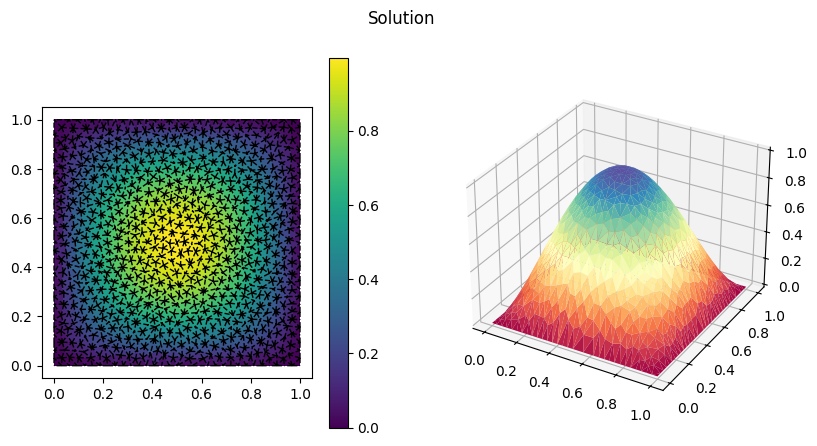

In [90]:
gedim.PlotSolution(mesh, dofs, strongs, uPrj, uStrong)

## 4.2 POD-nn without exact solution

### Offline phase - build reduced space

In [91]:
seed = 31
torch.manual_seed(seed)

trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))
snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet, exSolution=False)
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0134591997948438e-02 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.7711447174923798e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0134591997948438e-02 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.7711447174923798e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0134591997948438e-02 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.7711447174923798e-06 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Offline phase - network

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(inputDimension, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, N)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)

### Offline phase - training

epoch 500 loss 182.56784057617188 lr 0.001
epoch 1000 loss 27.1812801361084 lr 0.001
epoch 1500 loss 2.104027032852173 lr 0.0001
epoch 2000 loss 1.5065932273864746 lr 0.0001
epoch 2500 loss 0.9702555537223816 lr 0.0001
epoch 3000 loss 0.5490339398384094 lr 0.0001
epoch 3500 loss 0.2645486891269684 lr 0.0001
epoch 4000 loss 0.10403339564800262 lr 0.0001
epoch 4500 loss 0.03152582421898842 lr 0.0001
epoch 5000 loss 0.006816889625042677 lr 0.0001
epoch 5500 loss 0.0009501932072453201 lr 0.0001
epoch 6000 loss 7.469512638635933e-05 lr 0.0001
epoch 6500 loss 2.797648676278186e-06 lr 0.0001


<Figure size 640x480 with 0 Axes>

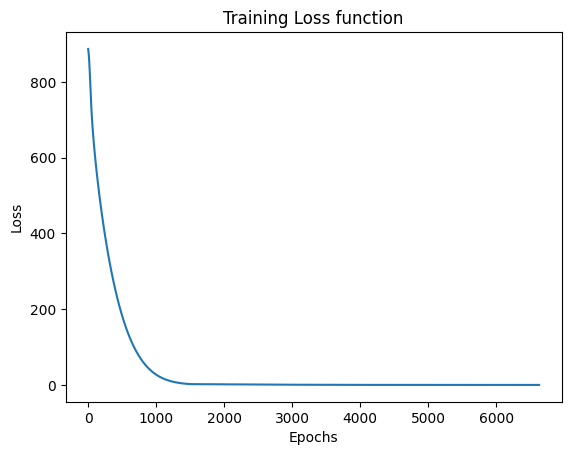

In [104]:
reducedInnerProduct = np.transpose(basisFunctions) @ innerProduct @ basisFunctions
xTrain = torch.tensor(np.float32(trainingSet))
yTrain = []
for i in range(snapshotMatrix.shape[0]):
    snapshot = snapshotMatrix[i]
    projectedSnapshot = np.linalg.solve(reducedInnerProduct, np.transpose(basisFunctions) @ innerProduct @ snapshot)
    yTrain.append(projectedSnapshot)
yTrain = np.float32(yTrain)
yTrain = torch.tensor(yTrain)

trainingLoss = []
epoch = 0
loss = 1.0
while loss >= tolerance and epoch < maxEpoches:
    epoch = epoch + 1
    optimizer.zero_grad()
    output = net(xTrain)
    loss = mse(output, yTrain) 
    if epoch >= 1500:
        optimizer.param_groups[0]['lr'] = 0.0001 # If lr is too large we don't follow the gradient direction but we could jump
    loss.backward()
    optimizer.step()
    trainingLoss.append(loss.item())
    if epoch % 500 == 0:
        print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

PATH = "modelUnknownSolutionPODNN.pth"
torch.save(net.state_dict(), PATH)
net.load_state_dict(torch.load(PATH, weights_only=True))

plt.clf()
plt.figure()
plt.plot(range(0, len(trainingLoss)), trainingLoss)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('trainingloss_podnn_unknownsolution.png')

### POD-nn errors and speedUp

In [106]:
def timePodnn(testingSet, net):
    startTime = time.time()
    for mu in testingSet:
        predictPODNN([mu], net)
    meanTime = (time.time() - startTime) / len(testingSet)
    print(f'Mean PODNN prediction time:', meanTime)
    return meanTime

def errorPodnnVsFom(uPodnn, uFom, uStrong):
    [numQuadraturePoints, _, quadratureWeights, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(uPodnn, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(uFom, uStrong, lib)
    errorL2Podnn = np.float64(0)
    errorH1Podnn = np.float64(0)
    normL2 = np.float64(0)
    normH1 = np.float64(0)
    for q in range(numQuadraturePoints):
        errorL2Podnn = errorL2Podnn + (quadratureWeights[q] * np.square(solFom[q] - sol[q]))
        errorH1Podnn = errorH1Podnn + (quadratureWeights[q] * (np.square(solXFom[q] - solX[q]) + np.square(solYFom[q] - solY[q])))
        normL2 = normL2 + (quadratureWeights[q] * np.square(solFom[q]))
        normH1 = normH1 + (quadratureWeights[q] * (np.square(solXFom[q]) + np.square(solYFom[q])))
    return np.sqrt(errorL2Podnn), np.sqrt(errorH1Podnn), np.sqrt(normL2), np.sqrt(normH1)

####################################################################################################################################

absoluteErrorL2 = []
absoluteErrorH1 = []
relativeErrorL2 = []
relativeErrorH1 = []
fomSolutions = []
testingSize = 100
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(testingSize, P.shape[0]))
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

# FOM
fomTime = time.time()
for mu in testingSet:
    fomSolutions.append(fom(mu, lib, problemData, exactSol=False)[0])
fomTime = time.time() - fomTime
meanTimeFom = fomTime / testingSize

# SpeedUp
meanTimePodnn = timePodnn(testingSet, net)
speedUpPodnn = meanTimeFom / meanTimePodnn

# Errors
for i in range(len(testingSet)):
    uPrj = predictPODNN([testingSet[i]], net)
    [errorL2Podnn, errorH1Podnn, normL2, normH1] = errorPodnnVsFom(uPrj, fomSolutions[i], uStrong)
    absoluteErrorL2.append(errorL2Podnn)
    absoluteErrorH1.append(errorH1Podnn)
    relativeErrorL2.append(errorL2Podnn / normL2)
    relativeErrorH1.append(errorH1Podnn / normH1)
print("\nAverage Relative L2 error:", np.mean(relativeErrorL2))
print("Average Absolute L2 error:", np.mean(absoluteErrorL2))
print("Average Relative H1 error:", np.mean(relativeErrorH1))
print("Average Absolute H1 error:", np.mean(absoluteErrorH1))
print("SpeedUp:", speedUpPodnn)

pd.DataFrame({'RelativeL2_FOMvsPODNN': [np.mean(relativeErrorL2)], 'AbsoluteL2_FOMvsPODNN': [np.mean(absoluteErrorL2)], 'RelativeH1_FOMvsPODNN': [np.mean(relativeErrorH1)], 'AbsoluteH1_FOMvsPODNN': [np.mean(absoluteErrorH1)], 'SpeedUp_PODNN': [speedUpPodnn]}).to_csv("PODNNquadratures.csv")

dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.6030371551860544e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.4437724795196925e-08 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.7771138075741781e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.2022415701282597e-07 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.6591103749522594e-03 2 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.4557508352827762e-09 3 25
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 25
dofs h residual iteration max_iteration
713 6.4341

### Plot solution

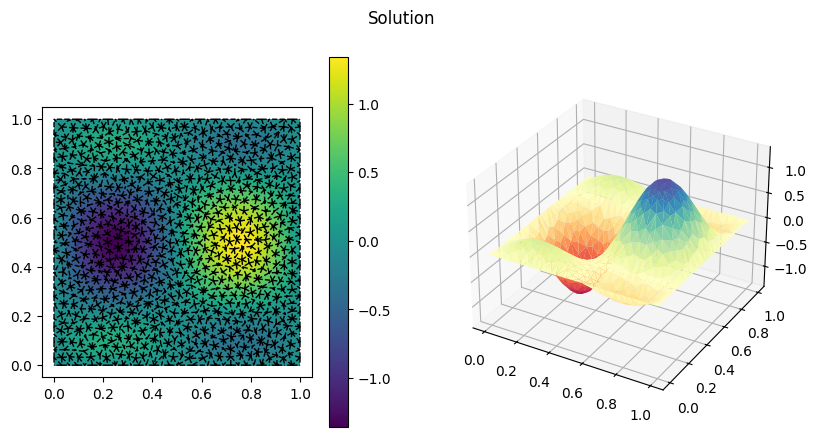

In [108]:
uPrj = predictPODNN([mu], net)

gedim.PlotSolution(mesh, dofs, strongs, uPrj, uStrong)

gedim.ExportSolution(exactSolution, uPrj, uStrong, lib)